# Гераськин Ярослав

**Общая информация**
**Срок сдачи:** 18 октября 2017, 06:00 <br/>
**Штраф за опоздание:** -2 балла после 06:00 18 октября, -4 балла после 06:00 25 октября, -6 баллов после 06:00 1 ноября

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий в slack @alkhamush

Необходимо в slack создать таск в приватный чат:
/todo Фамилия Имя ссылка на гитхаб @alkhamush
Пример:
/todo Ксения Стройкова https://github.com/stroykova/spheremailru/stroykova_hw1.ipynb @alkhamush
Дополнительно нужно просто скинуть ссылку в slack в личный чат

Используйте данный Ipython Notebook при оформлении домашнего задания.

###### Задание 1 (2 баллов)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. Самостоятельно разберитесь, как считается score из KNeighborsClassifier и реализуйте аналог в своём классе. Score не должен уступать значению KNN из sklearn

###### Задание 2 (2 балла)
Добиться скорости работы на fit,  predict и predict_proba сравнимой со sklearn для iris и mnist
Для этого используем numpy

###### Задание 3 (2 балла)
Для iris найдите такой параметр n_neighbors, при котором выдаётся наилучший score. Нарисуйте график зависимости score от n_neighbors

###### Задание 4 (3 балла)
Добавить algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Значение n_neighbors нужно взять из задания 3. Добиться скорости работы на fit,  predict и predict_proba сравнимой со sklearn для iris и mnist
Для этого используем numpy. Score не должен уступать значению KNN из sklearn

###### Задание 5 (1 балла)
Описать для чего нужны следующие библиотеки/классы/функции (список будет ниже)

**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять структуру кода и текст. В противном случае -1 балл


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn import datasets
from sklearn.base import ClassifierMixin
from sklearn.datasets import fetch_mldata
from sklearn.neighbors.base import NeighborsBase, KNeighborsMixin, SupervisedIntegerMixin 
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier, KDTree
from scipy.stats import mode
from functools import partial
from sklearn.preprocessing import StandardScaler, MinMaxScaler

%load_ext pycodestyle_magic

/home/rickya/anaconda3/lib/python3.7/site-packages/pycodestyle.py:113: FutureWarning: Possible nested set at position 1
  EXTRANEOUS_WHITESPACE_REGEX = re.compile(r'[[({] | []}),;:]')


In [2]:
class MyKNeighborsClassifier(NeighborsBase,
                             KNeighborsMixin,
                             SupervisedIntegerMixin,
                             ClassifierMixin):

    def __init__(self, n_neighbors, algorithm='brute'):
        self._n_neighbors = n_neighbors
        self._algorithm = algorithm

    def fit(self, X, y):
        self._X = X.astype(np.float64)
        self._y = y.astype(np.int32)
        self._n_classes = np.unique(self._y).shape[0]

        if self._algorithm == 'brute':
            self._norm2 = (self._X ** 2).sum(axis=1)
        elif self._algorithm == 'kd_tree':
            self._kd = KDTree(self._X)
        else:
            raise ValueError('algorithm name should be "brute" or "kd_tree"')

    def _dist(self, X):
        norm2 = (X ** 2).sum(axis=1)

        dist2 = -2 * X.dot(self._X.T)
        dist2 += norm2[:, np.newaxis]
        dist2 += self._norm2[np.newaxis, :]

        return dist2

    def _extract_neighbors(self, X):
        X = X.astype(np.float64)
        if self._algorithm == 'brute':
            dist2 = self._dist(X)

            ids = np.argpartition(
                dist2,
                self._n_neighbors
            )[:, :self._n_neighbors]

            return self._y[ids]
        elif self._algorithm == 'kd_tree':
            ids = self._kd.query(X, k=self._n_neighbors, return_distance=False)
            return self._y[ids]
        else:
            raise ValueError('algorithm name should be "brute" or "kd_tree"')

    def predict(self, X):
        neighbors = self._extract_neighbors(X)
        return mode(neighbors, axis=1)[0].ravel()

    def predict_proba(self, X):
        neighbors = self._extract_neighbors(X)
        counter = partial(np.bincount, minlength=self._n_classes)
        return np.apply_along_axis(counter, 1, neighbors) / self._n_neighbors

    def score(self, X, y):
        y = y.astype(np.int32)
        return (self.predict(X) == y).astype(np.float64).mean()

**IRIS**

In [3]:
seed = 4124

In [4]:
iris = datasets.load_iris()

In [5]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target, random_state=seed)

In [6]:
clf = KNeighborsClassifier(n_neighbors=2)
my_clf = MyKNeighborsClassifier(n_neighbors=2)

In [7]:
%time clf.fit(X_train, y_train)

CPU times: user 530 µs, sys: 38 µs, total: 568 µs
Wall time: 414 µs


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=2, p=2,
           weights='uniform')

In [8]:
%time my_clf.fit(X_train, y_train)

CPU times: user 488 µs, sys: 34 µs, total: 522 µs
Wall time: 369 µs


In [9]:
%time clf.predict(X_test)

CPU times: user 865 µs, sys: 60 µs, total: 925 µs
Wall time: 739 µs


array([2, 0, 1, 2, 2, 0, 1, 2, 0, 1, 1, 0, 1, 0, 2])

In [10]:
%time my_clf.predict(X_test)

CPU times: user 3.41 ms, sys: 181 µs, total: 3.59 ms
Wall time: 24.3 ms


array([2, 0, 1, 2, 2, 0, 1, 2, 0, 1, 1, 0, 1, 0, 2], dtype=int32)

In [11]:
%time a = clf.predict_proba(X_test)

CPU times: user 1.01 ms, sys: 68 µs, total: 1.08 ms
Wall time: 827 µs


In [12]:
%time b = my_clf.predict_proba(X_test)

CPU times: user 0 ns, sys: 1.78 ms, total: 1.78 ms
Wall time: 1.1 ms


In [13]:
clf.score(X_test, y_test)

0.8666666666666667

In [14]:
my_clf.score(X_test, y_test)

0.8666666666666667

Задание 3

Max score: 0.972266666666668, 14 neighbors


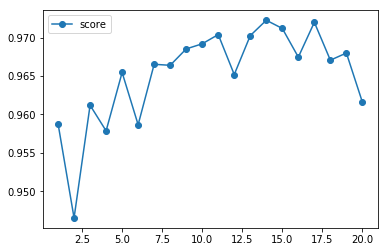

In [15]:
n, best = 0, 0
scores = []
n_tests = 500

for k in range(1, 21):
    clf = MyKNeighborsClassifier(k)
    score = 0

    for i in range(n_tests):
        X_train, X_test, y_train, y_test = train_test_split(
            iris.data,
            iris.target,
            test_size=0.1,
            stratify=iris.target,
            random_state=i
        )
        clf.fit(X_train, y_train)

        score += clf.score(X_test, y_test)

    scores.append(score / n_tests)

    if best < scores[-1]:
        n, best = k, scores[-1]

print('Max score: {}, {} neighbors'.format(best, n))

plt.plot(range(1, 21), scores, 'o-', label='score')
plt.legend();

**MNIST**

In [16]:
mnist = fetch_mldata('MNIST original')

In [17]:
X_train, X_test, y_train, y_test = train_test_split(mnist.data, mnist.target, test_size=0.01, stratify=mnist.target)

In [18]:
X_train.shape, X_test.shape

((69300, 784), (700, 784))

In [19]:
clf = KNeighborsClassifier(n_neighbors=2)
my_clf = MyKNeighborsClassifier(n_neighbors=2)

In [20]:
%time clf.fit(X_train, y_train)

CPU times: user 32.6 s, sys: 160 ms, total: 32.8 s
Wall time: 32.7 s


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=2, p=2,
           weights='uniform')

In [21]:
%time my_clf.fit(X_train, y_train)

CPU times: user 223 ms, sys: 228 ms, total: 452 ms
Wall time: 217 ms


In [22]:
%time clf.predict(X_test)

CPU times: user 1min 13s, sys: 51.5 ms, total: 1min 13s
Wall time: 1min 12s


array([5., 0., 8., 8., 1., 0., 7., 1., 1., 1., 2., 8., 3., 7., 2., 0., 2.,
       0., 0., 5., 7., 5., 1., 3., 2., 3., 4., 4., 3., 6., 8., 9., 4., 0.,
       7., 3., 1., 8., 1., 1., 1., 6., 6., 4., 2., 2., 6., 4., 2., 9., 1.,
       7., 6., 3., 5., 0., 0., 0., 9., 5., 6., 5., 6., 8., 2., 4., 8., 9.,
       9., 7., 9., 3., 3., 9., 6., 6., 0., 6., 7., 8., 2., 7., 8., 2., 5.,
       6., 9., 8., 3., 9., 5., 5., 5., 7., 5., 4., 0., 3., 7., 4., 1., 6.,
       1., 9., 2., 0., 9., 6., 7., 1., 3., 5., 4., 0., 6., 7., 6., 5., 5.,
       8., 4., 4., 3., 7., 4., 5., 2., 0., 0., 4., 1., 0., 0., 1., 1., 3.,
       4., 0., 7., 7., 3., 1., 0., 2., 3., 1., 7., 0., 3., 6., 7., 1., 9.,
       1., 9., 2., 3., 7., 3., 0., 3., 2., 9., 8., 2., 3., 4., 5., 8., 1.,
       2., 2., 2., 8., 5., 9., 0., 3., 6., 5., 9., 9., 9., 0., 2., 2., 3.,
       4., 8., 4., 7., 5., 6., 1., 2., 6., 2., 9., 0., 3., 7., 4., 0., 6.,
       2., 2., 2., 7., 7., 9., 8., 1., 5., 3., 5., 5., 0., 7., 9., 3., 2.,
       0., 6., 1., 5., 8.

In [23]:
%time my_clf.predict(X_test)

CPU times: user 4.08 s, sys: 268 ms, total: 4.34 s
Wall time: 1.34 s


array([5, 0, 8, 8, 1, 0, 7, 1, 1, 1, 2, 8, 3, 7, 2, 0, 2, 0, 0, 5, 7, 5,
       1, 3, 2, 3, 4, 4, 3, 6, 8, 9, 4, 0, 7, 3, 1, 8, 1, 1, 1, 6, 6, 4,
       2, 2, 6, 4, 2, 9, 1, 7, 6, 3, 5, 0, 0, 0, 9, 5, 6, 5, 6, 8, 2, 4,
       8, 9, 9, 7, 9, 3, 3, 9, 6, 6, 0, 6, 7, 8, 2, 7, 8, 2, 5, 6, 9, 8,
       3, 9, 5, 5, 5, 7, 5, 4, 0, 3, 7, 4, 1, 6, 1, 9, 2, 0, 9, 6, 7, 1,
       3, 5, 4, 0, 6, 7, 6, 5, 5, 8, 4, 4, 3, 7, 4, 5, 2, 0, 0, 4, 1, 0,
       0, 1, 1, 3, 4, 0, 7, 7, 3, 1, 0, 2, 3, 1, 7, 0, 3, 6, 7, 1, 9, 1,
       9, 2, 3, 7, 3, 0, 3, 2, 9, 8, 2, 3, 4, 5, 8, 1, 2, 2, 2, 8, 5, 9,
       0, 3, 6, 5, 9, 9, 9, 0, 2, 2, 3, 4, 8, 4, 7, 5, 6, 1, 2, 6, 2, 9,
       0, 3, 7, 4, 0, 6, 2, 2, 2, 7, 7, 9, 8, 1, 5, 3, 5, 5, 0, 7, 9, 3,
       2, 0, 6, 1, 5, 8, 0, 0, 3, 7, 1, 8, 9, 9, 6, 6, 0, 6, 8, 6, 6, 0,
       9, 6, 4, 5, 0, 4, 4, 7, 2, 5, 1, 0, 9, 4, 0, 1, 2, 8, 8, 8, 9, 1,
       3, 7, 7, 8, 3, 6, 4, 7, 3, 1, 3, 3, 6, 4, 6, 9, 1, 3, 9, 4, 3, 7,
       1, 8, 6, 9, 4, 4, 9, 8, 0, 2, 5, 9, 2, 0, 0,

In [24]:
%time clf.predict_proba(X_test)

CPU times: user 1min 9s, sys: 91.9 ms, total: 1min 9s
Wall time: 1min 9s


array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [25]:
%time my_clf.predict_proba(X_test)

CPU times: user 4.5 s, sys: 220 ms, total: 4.72 s
Wall time: 1.44 s


array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [26]:
clf.score(X_test, y_test)

0.9742857142857143

In [27]:
my_clf.score(X_test, y_test)

0.9742857142857143

Задание 4

Нахожу странным использование n_neighbors, посчитанного на другом датасете

In [28]:
clf = KNeighborsClassifier(n_neighbors=14, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=14, algorithm='kd_tree')

In [29]:
X_train, X_test, y_train, y_test = train_test_split(mnist.data, mnist.target, test_size=0.01, stratify=mnist.target)

In [30]:
%time clf.fit(X_train, y_train)

CPU times: user 38.3 s, sys: 180 ms, total: 38.5 s
Wall time: 38.4 s


KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=14, p=2,
           weights='uniform')

In [31]:
%time my_clf.fit(X_train, y_train)

CPU times: user 31 s, sys: 180 ms, total: 31.2 s
Wall time: 31.1 s


In [32]:
%time clf.predict(X_test)

CPU times: user 1min 9s, sys: 36 ms, total: 1min 9s
Wall time: 1min 10s


array([3., 9., 3., 6., 9., 5., 9., 7., 5., 3., 6., 0., 0., 9., 2., 1., 6.,
       4., 5., 3., 5., 8., 9., 1., 4., 6., 0., 2., 8., 5., 1., 7., 8., 6.,
       4., 1., 1., 7., 3., 2., 9., 5., 6., 6., 6., 1., 3., 6., 5., 5., 9.,
       1., 2., 4., 6., 3., 9., 3., 6., 9., 1., 0., 7., 8., 2., 0., 7., 4.,
       1., 3., 3., 7., 0., 4., 0., 3., 1., 1., 2., 4., 2., 0., 7., 9., 9.,
       0., 4., 5., 7., 9., 7., 3., 2., 1., 3., 1., 3., 6., 7., 7., 2., 2.,
       0., 4., 3., 0., 8., 8., 2., 0., 3., 3., 9., 8., 8., 7., 3., 8., 6.,
       0., 9., 5., 5., 9., 8., 9., 5., 6., 2., 7., 4., 0., 6., 9., 1., 2.,
       7., 3., 1., 3., 2., 6., 3., 4., 8., 2., 9., 4., 0., 8., 1., 6., 7.,
       2., 2., 0., 7., 2., 1., 7., 0., 3., 7., 0., 6., 2., 7., 1., 9., 0.,
       4., 4., 1., 0., 3., 3., 8., 9., 3., 1., 6., 1., 0., 7., 5., 7., 1.,
       0., 8., 4., 0., 7., 5., 5., 9., 4., 2., 8., 2., 1., 2., 9., 5., 2.,
       9., 9., 9., 0., 7., 4., 1., 2., 7., 9., 8., 0., 5., 1., 4., 8., 4.,
       5., 8., 6., 4., 9.

In [33]:
%time my_clf.predict(X_test)

CPU times: user 57.3 s, sys: 3.98 ms, total: 57.3 s
Wall time: 57.3 s


array([3, 9, 3, 6, 9, 5, 9, 7, 5, 3, 6, 0, 0, 9, 2, 1, 6, 4, 5, 3, 5, 8,
       9, 1, 4, 6, 0, 2, 8, 5, 1, 7, 8, 6, 4, 1, 1, 7, 3, 2, 9, 5, 6, 6,
       6, 1, 3, 6, 5, 5, 9, 1, 2, 4, 6, 3, 9, 3, 6, 9, 1, 0, 7, 8, 2, 0,
       7, 4, 1, 3, 3, 7, 0, 4, 0, 3, 1, 1, 2, 4, 2, 0, 7, 9, 9, 0, 4, 5,
       7, 9, 7, 3, 2, 1, 3, 1, 3, 6, 7, 7, 2, 2, 0, 4, 3, 0, 8, 8, 2, 0,
       3, 3, 9, 8, 8, 7, 3, 8, 6, 0, 9, 5, 5, 9, 8, 9, 5, 6, 2, 7, 4, 0,
       6, 9, 1, 2, 7, 3, 1, 3, 2, 6, 3, 4, 8, 2, 9, 4, 0, 8, 1, 6, 7, 2,
       2, 0, 7, 2, 1, 7, 0, 3, 7, 0, 6, 2, 7, 1, 9, 0, 4, 4, 1, 0, 3, 3,
       8, 9, 3, 1, 6, 1, 0, 7, 5, 7, 1, 0, 8, 4, 0, 7, 5, 5, 9, 4, 2, 8,
       2, 1, 2, 9, 5, 2, 9, 9, 9, 0, 7, 4, 1, 2, 7, 9, 8, 0, 5, 1, 4, 8,
       4, 5, 8, 6, 4, 9, 1, 1, 1, 0, 5, 0, 7, 7, 7, 4, 3, 4, 9, 6, 5, 9,
       3, 3, 1, 5, 7, 4, 3, 6, 1, 1, 0, 9, 3, 8, 1, 7, 0, 1, 7, 4, 7, 2,
       1, 4, 4, 4, 6, 2, 8, 7, 1, 6, 1, 7, 0, 3, 0, 7, 7, 1, 9, 6, 9, 8,
       6, 8, 7, 6, 5, 2, 1, 5, 5, 1, 1, 2, 9, 5, 4,

In [34]:
%time clf.predict_proba(X_test)

CPU times: user 1min 9s, sys: 27.9 ms, total: 1min 9s
Wall time: 1min 9s


array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.92857143]])

In [35]:
%time my_clf.predict_proba(X_test)

CPU times: user 57.5 s, sys: 12 ms, total: 57.5 s
Wall time: 57.5 s


array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.92857143]])

In [36]:
clf.score(X_test, y_test)

0.9642857142857143

In [37]:
my_clf.score(X_test, y_test)

0.9642857142857143

Задание 5

seaborn - библиотека для визуализации данных, основана на matplotlib\<br/>
matplotlib - библиотека для построения графиков визуализации данных<br/>
train_test_split - разбивает данные на тренеровочную и тестовую части<br/>
Pipeline (from sklearn.pipeline import Pipeline) - класс, позволяющий последовательно обрабатывать данные (например PCA + KNN)<br/>
StandardScaler (from sklearn.preprocessing import StandardScaler) - нормирует данные в отрезок (-1, 1) так, что mean=0, std=1<br/>
ClassifierMixin - базовый класс для классификаторов sklearn<br/>
NeighborsBase - базовый класс для ближайших соседей<br/>
KNeighborsMixin - базовый класс для поиска к соседей<br/>
SupervisedIntegerMixin - базовый класс для обучения на данных (X, y) (метод fit)